# AC 221 Final Project - COVID-19 Datasets and Privacy
## Jordan Turley

In this notebook, I look at an individual-level dataset of confirmed cases of COVID-19 in India. Most datasets only provide the number of confirmed cases in the entire country, or at the county level in America, but we were lucky to find this dataset which provides information on individuals that have been confirmed to have the coronavirus. The dataset comes from https://www.covid19india.org/, specifically https://api.covid19india.org/csv/latest/death_and_recovered.csv, and was downloaded on April 26, 2020.

In [94]:
import csv
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [41]:
# Helper functions for use later

def naToStr(df, columns):
    '''Convert the na/nan values in a pd dataframe to the string "NaN".'''
    for col in columns:
        df.loc[df[col].isna(), col] = 'NaN'
        
def strToNa(df, columns):
    '''Convert the string values "NaN" back to actual nan'''
    for col in columns:
        df.loc[df[col] == 'NaN', col] = np.nan
        
def oneHotEncoding(df, columns):
    '''Perform one-hot encoding for given columns'''
    d = pd.get_dummies(df[columns], drop_first = True)
    df[d.columns] = d
    df.drop(columns, axis = 1, inplace = True)
        
def imputeMeanWithNA(df, column):
    '''Provides one method to fix missing value for a quantitative column.
    Creates a new 0/1 column indicating whether the original column was na/nan,
    and imputes the mean to the original column where there were na/nan values.
    '''
    df[column + ' NaN'] = df[column].isna().astype(int)
    df.loc[df[column].isna(), column] = df[column].mean()

## Data Cleaning

First, we have to process the csv file. About half of the lines have a random extra comma at the end, causing problems. It seemed like there was no problem with just chopping off this comma, except for specifically one row (line 6312). I figured it wouldn't be a problem to just discard this one line, so for this line, we just skip it by specifying `error_bad_lines = False`. 

In [3]:
# Remove the trailing comma from half of the rows
f = open('death_and_recovered.csv')
outf = open('death_and_recovered_fixed.csv', 'w')
c = 0
for line in f:
    c += 1
    
    line = line.strip()
    
    row = csv.reader([line])
    row = list(row)[0]
    
    if len(row) == 16:
        line = line[:-1]
        
    outf.write(line + '\n')
        

f.close()
outf.close()

In [4]:
df = pd.read_csv('death_and_recovered_fixed.csv', index_col = 'Sl_No', error_bad_lines = False)

b'Skipping line 6312: expected 15 fields, saw 16\n'


In [5]:
df.head()

,Date,Age Bracket,Gender,Patient_Status,City,District,State,Statecode,Notes,Nationality,Source_1,Source_2,Source_3,Patient_Number (Could be mapped later)
Sl_No,,,,,,,,,,,,,,
59,13/03/2020,NaN,NaN,Deceased,NaN,NaN,Karnataka,KA,KA-P6,NaN,Opening Data as of Mar 29,NaN,NaN,P74
54,20/03/2020,NaN,NaN,Recovered,NaN,NaN,Karnataka,KA,KA-P5,NaN,Opening Data as of Mar 29,NaN,NaN,NaN
55,24/03/2020,NaN,NaN,Recovered,NaN,NaN,Karnataka,KA,KA-P2,NaN,Opening Data as of Mar 29,NaN,NaN,NaN
56,24/03/2020,NaN,NaN,Recovered,NaN,NaN,Karnataka,KA,KA-P4,NaN,Opening Data as of Mar 29,NaN,NaN,NaN
60,26/03/2020,NaN,NaN,Deceased,NaN,NaN,Karnataka,KA,KA-P53,NaN,Opening Data as of Mar 29,NaN,NaN,P690


In [6]:
len(df)

6853

We see we have almost 7000 rows in this dataset. Below, we drop some of the useless columns, like the sources, patient number (all NaN except for about 100 rows), and convert others to their proper data types. We also drop State since we have Statecode, and the two are redundant.

In [7]:
df.dtypes

Date                                       object
Age Bracket                               float64
Gender                                     object
Patient_Status                             object
City                                       object
District                                   object
State                                      object
Statecode                                  object
Notes                                      object
Nationality                                object
Source_1                                   object
Source_2                                   object
Source_3                                   object
Patient_Number (Could be mapped later)     object
dtype: object

In [8]:
# Drop unneeded columns, convert the date to a datetime object
df.drop(['Source_1', 'Source_2', 'Source_3'], axis = 1, inplace = True, errors = 'ignore')
df.drop('Notes', axis = 1, inplace = True, errors = 'ignore')
df.drop('Patient_Number (Could be mapped later)', axis = 1, inplace = True, errors = 'ignore')
df.drop('State', axis = 1, inplace = True, errors = 'ignore') # Only keep Statecode

df['Date'] = pd.DatetimeIndex(df['Date'])

In [9]:
df.sample(20)

,Date,Age Bracket,Gender,Patient_Status,City,District,Statecode,Nationality
Sl_No,,,,,,,,
1620,2020-04-14,NaN,NaN,Recovered,NaN,NaN,TN,NaN
6563,2020-04-25,NaN,NaN,Recovered,NaN,NaN,UP,NaN
3602,2020-04-20,NaN,NaN,Recovered,NaN,NaN,UP,NaN
1125,2020-11-04,NaN,NaN,Recovered,NaN,NaN,RJ,NaN
6203,2020-04-24,NaN,NaN,Recovered,NaN,NaN,DL,NaN
892,2020-10-04,NaN,NaN,Recovered,NaN,Kasaragod,KL,NaN
1455,2020-04-13,NaN,NaN,Recovered,NaN,Kasaragod,KL,NaN
6779,2020-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3322,2020-04-19,NaN,NaN,Deceased,NaN,NaN,TG,NaN


## Exploratory Data Analysis

Below, we do some initial exploratory data analysis on the dataset. First, we simply look at the distribution of patient status. We see that the majority of our patients have recovered, but there are a significant number of deaths. We have a weird value for status of 'NotCountedbyAnyState#', but we just ignore this.

Text(0.5, 1.0, 'Distribution of Patient Status')

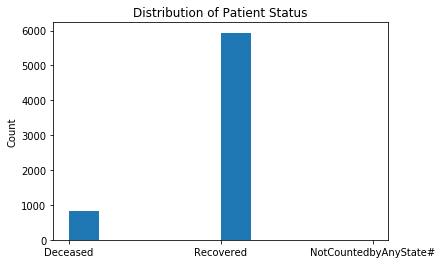

In [169]:
plt.hist(df['Patient_Status'].dropna())
plt.ylabel('Count')
plt.title('Distribution of Patient Status')

Next, we look at the distribution of State. We would have also looked at the distribution of the other geographical columns, like City or District, but there were too many to make much sense of. We see that the most cases in this dataset are in 'MH', or Maharashtra, which is the second most populated state of India.

Text(0.5, 1.0, 'Distribution of State/Statecode')

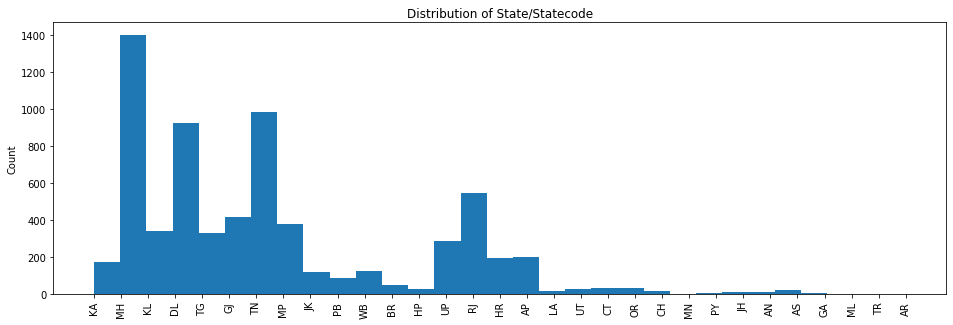

In [185]:
plt.figure(figsize = (16, 5))
plt.hist(df['Statecode'].dropna(), bins = len(df['Statecode'].dropna().unique()))
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.title('Distribution of State/Statecode')

We also look at the Nationality column, and see there are only two values: India and Italy. There are only 126 values that are not missing, but out of these, most are India.

In [188]:
print(df['Nationality'].unique())
print('India:', np.sum(df['Nationality'] == 'India'))
print('Italy:', np.sum(df['Nationality'] == 'Italy'))

[nan 'Italy' 'India']
India: 112
Italy: 14


Next, we look at the distribution of age. We look at both the overall distribution of the dataset, as well as the difference in the distributions for individuals that have recovered and that died. We see that the ages have the highest frequency between about 40 and 70. We also see hard proof that the virus is more deadly to older people. We see a clear difference between the age of individuals who have recovered and who died.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


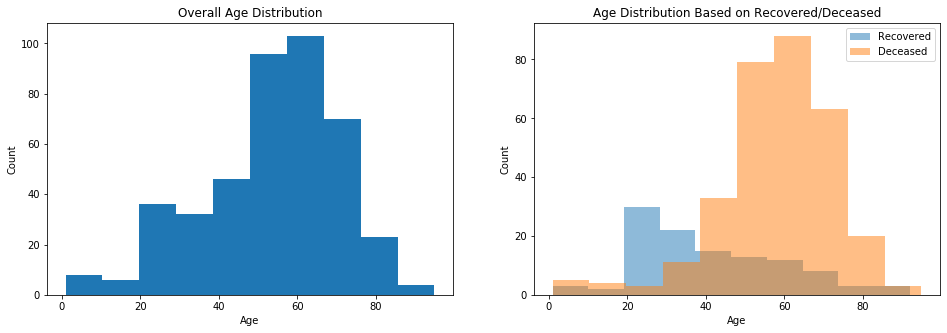

In [10]:
plt.figure(figsize = (16, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Age Bracket'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Overall Age Distribution')

plt.subplot(1, 2, 2)
plt.hist(df['Age Bracket'][df['Patient_Status'] == 'Recovered'], alpha = 0.5)
plt.hist(df['Age Bracket'][df['Patient_Status'] == 'Deceased'], alpha = 0.5)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution Based on Recovered/Deceased')
plt.legend(['Recovered', 'Deceased'])

Next we look at the distribution of gender. We see that the overwhelming majority of the data is missing, which will soon become a pattern, but out of the data we do have, there are about twice as many men as women in the dataset. We also look at the distribution of Deceased and Recovered based on gender for the individuals that we have this data on. We see that it looks like a slightly higher proportion of men have died, but not a significantly higher number. The data is so limited that this is probably just due to chance. This plot makes it look like the disease has a 50% death rate, but it's just because the rest of the gender data is missing.

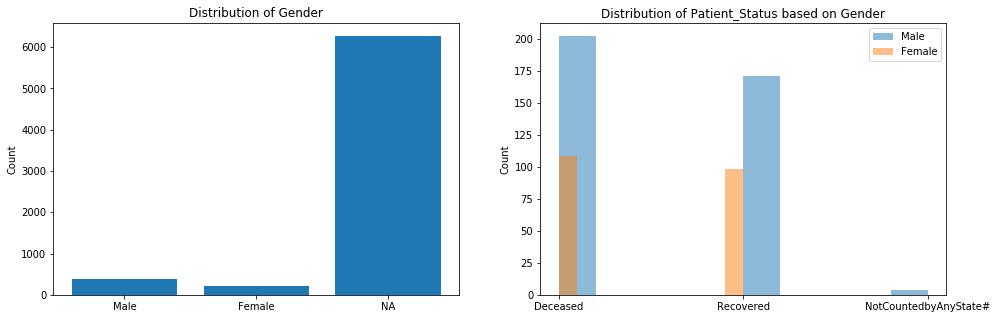

In [170]:
# There is one row where gender = 'W', I'll just ignore this
genderMale = np.sum(df['Gender'] == 'M')
genderFemale = np.sum(df['Gender'] == 'F')
genderNA = np.sum(df['Gender'].isna())

plt.figure(figsize = (16, 5))

plt.subplot(1, 2, 1)
plt.bar(['Male', 'Female', 'NA'], [genderMale, genderFemale, genderNA])
plt.ylabel('Count')
plt.title('Distribution of Gender')

plt.subplot(1, 2, 2)
plt.hist(df[df['Gender'] == 'M']['Patient_Status'], alpha = 0.5)
plt.hist(df[df['Gender'] == 'F']['Patient_Status'], alpha = 0.5)
plt.ylabel('Count')
plt.title('Distribution of Patient_Status based on Gender')
plt.legend(['Male', 'Female'])

#genderMale, genderFemale

## Anonymity and Privacy

Next, we analyze the $k$-anonymity of the dataset. We see that there is no directory information in this dataset, like name or street address, which we would expect since this is medical data that has been released. This data was released in India, so I am not sure that they have to abide by HIPAA, but I would assume that the dataset would be pretty close to HIPAA compliant, which only specifies that directory information must be removed.

We do, however, find several quasi-identifiers. We list these below:

* Age Bracket
* Gender
* City
* District
* Statecode
* Nationality

In theory, these could be used to match an individual here to another dataset and uniquely identify that individual. Below, we calculate the $k$-anonymity of the dataset.

In [11]:
dfKAnon = df.copy()

# Convert the nan's to strings since they're easier to deal with this way.
# We'll convert them back if needed later
naToStr(dfKAnon, dfKAnon.columns)

kAnonDict = {}
for i1 in range(len(dfKAnon)):
    row = dfKAnon.iloc[i1]
    key = (row['Age Bracket'], row['Gender'], row['City'], row['District'], row['Statecode'], row['Nationality'])
    if key not in kAnonDict:
        kAnonDict[key] = 0
    kAnonDict[key] += 1

In [12]:
# Sort based on the key, i.e. the number of times this pattern appeared in the dataset
sortedKAnonDict = sorted(kAnonDict.items(), key = operator.itemgetter(1))

In [13]:
# Top ten most common keys
sortedKAnonDict[-10:]

[(('NaN', 'NaN', 'NaN', 'Kasaragod', 'KL', 'NaN'), 142),
 (('NaN', 'NaN', 'NaN', 'Mumbai', 'MH', 'NaN'), 149),
 (('NaN', 'NaN', 'NaN', 'NaN', 'KA', 'NaN'), 151),
 (('NaN', 'NaN', 'NaN', 'NaN', 'UP', 'NaN'), 237),
 (('NaN', 'NaN', 'NaN', 'NaN', 'MP', 'NaN'), 304),
 (('NaN', 'NaN', 'NaN', 'NaN', 'TG', 'NaN'), 320),
 (('NaN', 'NaN', 'NaN', 'NaN', 'RJ', 'NaN'), 488),
 (('NaN', 'NaN', 'NaN', 'NaN', 'DL', 'NaN'), 921),
 (('NaN', 'NaN', 'NaN', 'NaN', 'TN', 'NaN'), 961),
 (('NaN', 'NaN', 'NaN', 'NaN', 'MH', 'NaN'), 1078)]

In [14]:
# Top ten least common keys
sortedKAnonDict[:10]

[((85.0, 'M', 'Mumbai', 'Mumbai', 'MH', 'NaN'), 1),
 ((80.0, 'M', 'Mumbai', 'Mumbai', 'MH', 'NaN'), 1),
 ((86.0, 'F', 'Ghatkopar', 'Mumbai Suburban', 'MH', 'NaN'), 1),
 ((45.0, 'M', 'NaN', 'Buldana', 'MH', 'NaN'), 1),
 ((74.0, 'M', 'Hyderabad', 'Hyderabad', 'TG', 'NaN'), 1),
 ((67.0, 'M', 'Surat', 'Surat', 'GJ', 'NaN'), 1),
 ((85.0, 'F', 'Ahmadabad', 'Ahmadabad', 'GJ', 'NaN'), 1),
 ((70.0, 'M', 'Bhavnagar', 'Bhavnagar', 'GJ', 'NaN'), 1),
 ((46.0, 'F', 'Ahmadabad', 'Ahmadabad', 'GJ', 'NaN'), 1),
 ((47.0, 'M', 'Ahmadabad', 'Ahmadabad', 'GJ', 'NaN'), 1)]

In [18]:
# Calculate how many there are at each k level
kCounts = {}
for key, value in sortedKAnonDict:
    if value not in kCounts:
        kCounts[value] = 0
    kCounts[value] += 1
    
kCounts[1], kCounts[2], kCounts[3], kCounts[4], kCounts[5]

(417, 56, 24, 16, 12)

As we probably expected, the initial $k$-anonymity of this dataset is 1. This isn't too surprising. However, we do see that there are only 417 that are totally unique, and only a handful that are below 5-anonymous. In this case, missing data is our best friend. This dataset has a lot of missing data, which means that there aren't that many unique combinations of quasi-identifiers. This is good, and it means that if we do the most simple thing and drop these rows, then we only lose about 500 rows, which is only about 7% of the data. Below, we do just that.

NOTE: I plan to also try converting age to a range, like 0-10, 10-20, etc. and try other methods of anonymization than only this one.

In [19]:
threeAnonDF = dfKAnon.copy()
fourAnonDF = dfKAnon.copy()
fiveAnonDF = dfKAnon.copy()

for key, value in kAnonDict.items():
    age, gender, city, district, statecode, nationality = key
    
    indices = ~((threeAnonDF['Age Bracket'] == age) & (threeAnonDF['Gender'] == gender) & (threeAnonDF['City'] == city) \
             & (threeAnonDF['District'] == district) & (threeAnonDF['Statecode'] == statecode) \
             & (threeAnonDF['Nationality'] == nationality))
    
    if value <= 3:
        threeAnonDF = threeAnonDF[indices]
    
    if value <= 4:
        fourAnonDF = fourAnonDF[indices]
        
    if value <= 5:
        fiveAnonDF = fiveAnonDF[indices]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [20]:
len(threeAnonDF), len(fourAnonDF), len(fiveAnonDF)

(6252, 6188, 6128)

Even at 5-anonymity, we still have over 6000 records left to use.

## Prediction

Below, we will see how valid this data actually is for analysis. We will attempt to predict whether a person will recover or die from the virus. We see below that the dataset is not balanced at all, as we have almost 10 times as many recoveries as deaths. This is good for these people that have recovered, but bad for analysis. If we just predict "Recovered" for every data point we see, we could get an 87% accuracy, but this is worth nothing. We will try to do better than 87%.

If we wanted to get the best results possible, it would be smart to do some data balancing techniques, like up-sampling or down-sampling. However, in this case we don't care as much about getting the best accuracy. Of course this would be nice, but in this case, we want to see the differences between the original and the $k$-anonymous datasets and how making the dataset more anonymous affects our accuracy of prediction rather than trying to make the most accurate predictions possible.

In [25]:
recCount, decCount = np.sum(df['Patient_Status'] == 'Recovered'), np.sum(df['Patient_Status'] == 'Deceased')
recCount, decCount

(5938, 824)

In [190]:
print(((recCount / (recCount + decCount)) * 100).round(3), 'percent recovered')

87.814 percent recovered


Below, we will get the datasets ready for use for prediction. We first make copies, then we only keep data points where the patient either recovered or died. Next, we do some data processing to get the datasets ready for use with sklearn.

In [53]:
# Make a copy of the original dataset that we can modify for prediction
dfPrediction = df.copy()
df3Prediction = threeAnonDF.copy()
df4Prediction = fourAnonDF.copy()
df5Prediction = fiveAnonDF.copy()

In [54]:
# First, drop any rows where Patient_Status != Deceased or Recovered
dfPrediction = dfPrediction[(dfPrediction['Patient_Status'] == 'Deceased') | (dfPrediction['Patient_Status'] == 'Recovered')]
df3Prediction = df3Prediction[(df3Prediction['Patient_Status'] == 'Deceased') | (df3Prediction['Patient_Status'] == 'Recovered')]
df4Prediction = df4Prediction[(df4Prediction['Patient_Status'] == 'Deceased') | (df4Prediction['Patient_Status'] == 'Recovered')]
df5Prediction = df5Prediction[(df5Prediction['Patient_Status'] == 'Deceased') | (df5Prediction['Patient_Status'] == 'Recovered')]
len(dfNAFix), len(df3Prediction), len(df4Prediction), len(df5Prediction) # Still all over 6K

(6853, 6165, 6101, 6041)

In [55]:
# Convert the "NaN"s back to actual NaNs
strToNa(df3Prediction, ['Age Bracket'])
strToNa(df4Prediction, ['Age Bracket'])
strToNa(df5Prediction, ['Age Bracket'])

In [56]:
imputeMeanWithNA(dfPrediction, 'Age Bracket')
imputeMeanWithNA(df3Prediction, 'Age Bracket')
imputeMeanWithNA(df4Prediction, 'Age Bracket')
imputeMeanWithNA(df5Prediction, 'Age Bracket')

Below, we see a problem. In making the dataset 4- and 5-anonymous, we removed all of the unique ages and are only left with NaNs. As a result, we will just drop the entire age column. This will likely impact our ability to predict negatively.

In [57]:
df3Prediction['Age Bracket'].unique(), df4Prediction['Age Bracket'].unique(), df5Prediction['Age Bracket'].unique()

(array([52.5, 65.0, 40.0], dtype=object),
 array([nan], dtype=object),
 array([nan], dtype=object))

In [58]:
# Drop age from the 4- and 5-anonymous datasets
df4Prediction.drop(['Age Bracket', 'Age Bracket NaN'], axis = 1, inplace = True, errors = 'ignore')
df5Prediction.drop(['Age Bracket', 'Age Bracket NaN'], axis = 1, inplace = True, errors = 'ignore')

In [59]:
# Convert the NaN's to strings in the full dataset
# This makes it easier to one-hot encode
categoricalCols = ['Gender',
                   'Patient_Status',
                   'City',
                   'District',
                   'Statecode',
                   'Nationality']
naToStr(dfPrediction, categoricalCols)

In [60]:
# One hot encode the columns
oneHotEncoding(dfPrediction, categoricalCols)
oneHotEncoding(df3Prediction, categoricalCols)
oneHotEncoding(df4Prediction, categoricalCols)
oneHotEncoding(df5Prediction, categoricalCols)

In [62]:
dfPrediction.head()

,Date,Age Bracket,Age Bracket NaN,Gender_M,Gender_NaN,Gender_W,Patient_Status_Recovered,City_Ahmadabad,City_Ariyankuppam,City_Armpora Sopore,...,Statecode_PY,Statecode_RJ,Statecode_TG,Statecode_TN,Statecode_TR,Statecode_UP,Statecode_UT,Statecode_WB,Nationality_Italy,Nationality_NaN
Sl_No,,,,,,,,,,,,,,,,,,,,,
59,2020-03-13,53.67381,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
54,2020-03-20,53.67381,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
55,2020-03-24,53.67381,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
56,2020-03-24,53.67381,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
60,2020-03-26,53.67381,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [63]:
df3Prediction.head()

,Date,Age Bracket,Age Bracket NaN,Gender_M,Gender_NaN,Patient_Status_Recovered,City_Hyderabad,City_Malegaon,City_Mumbai,City_NaN,...,Statecode_OR,Statecode_PB,Statecode_RJ,Statecode_TG,Statecode_TN,Statecode_UP,Statecode_UT,Statecode_WB,Nationality_Italy,Nationality_NaN
Sl_No,,,,,,,,,,,,,,,,,,,,,
59,2020-03-13 00:00:00,52.5,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
54,2020-03-20 00:00:00,52.5,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
55,2020-03-24 00:00:00,52.5,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
56,2020-03-24 00:00:00,52.5,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
60,2020-03-26 00:00:00,52.5,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [64]:
df4Prediction.head()

,Date,Gender_M,Gender_NaN,Patient_Status_Recovered,City_Malegaon,City_Mumbai,City_NaN,City_Pimpri-Chinchwad,City_Pune,District_Ahmadabad,...,Statecode_OR,Statecode_PB,Statecode_RJ,Statecode_TG,Statecode_TN,Statecode_UP,Statecode_UT,Statecode_WB,Nationality_Italy,Nationality_NaN
Sl_No,,,,,,,,,,,,,,,,,,,,,
59,2020-03-13 00:00:00,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
54,2020-03-20 00:00:00,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
55,2020-03-24 00:00:00,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
56,2020-03-24 00:00:00,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
60,2020-03-26 00:00:00,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [65]:
df5Prediction.head()

,Date,Gender_M,Gender_NaN,Patient_Status_Recovered,City_Malegaon,City_Mumbai,City_NaN,City_Pimpri-Chinchwad,City_Pune,District_Ahmadabad,...,Statecode_OR,Statecode_PB,Statecode_RJ,Statecode_TG,Statecode_TN,Statecode_UP,Statecode_UT,Statecode_WB,Nationality_Italy,Nationality_NaN
Sl_No,,,,,,,,,,,,,,,,,,,,,
59,2020-03-13 00:00:00,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
54,2020-03-20 00:00:00,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
55,2020-03-24 00:00:00,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
56,2020-03-24 00:00:00,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
60,2020-03-26 00:00:00,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Now that the data is ready, we split each set into $X$ and $y$, then create logistic regression models with each to predict survival.

In [84]:
# Split each dataset into X and y data
y_full = dfPrediction['Patient_Status_Recovered']
X_full = dfPrediction.drop(['Patient_Status_Recovered', 'Date'], axis = 1)

y_3 = df3Prediction['Patient_Status_Recovered']
X_3 = df3Prediction.drop(['Patient_Status_Recovered', 'Date'], axis = 1)

y_4 = df4Prediction['Patient_Status_Recovered']
X_4 = df4Prediction.drop(['Patient_Status_Recovered', 'Date'], axis = 1)

y_5 = df5Prediction['Patient_Status_Recovered']
X_5 = df5Prediction.drop(['Patient_Status_Recovered', 'Date'], axis = 1)

Model: Full
Age Bracket coef = -0.051
Train accuracy: 0.955
Test accuracy: 0.945
[[ 112   55]
 [  19 1167]]

Model: 3-Anonymous
Age Bracket coef = -0.07
Train accuracy: 0.961
Test accuracy: 0.959
[[  57   47]
 [   4 1125]]

Model: 4-Anonymous
Train accuracy: 0.962
Test accuracy: 0.957
[[  51   50]
 [   3 1117]]

Model: 5-Anonymous
Train accuracy: 0.96
Test accuracy: 0.968
[[  45   35]
 [   4 1125]]



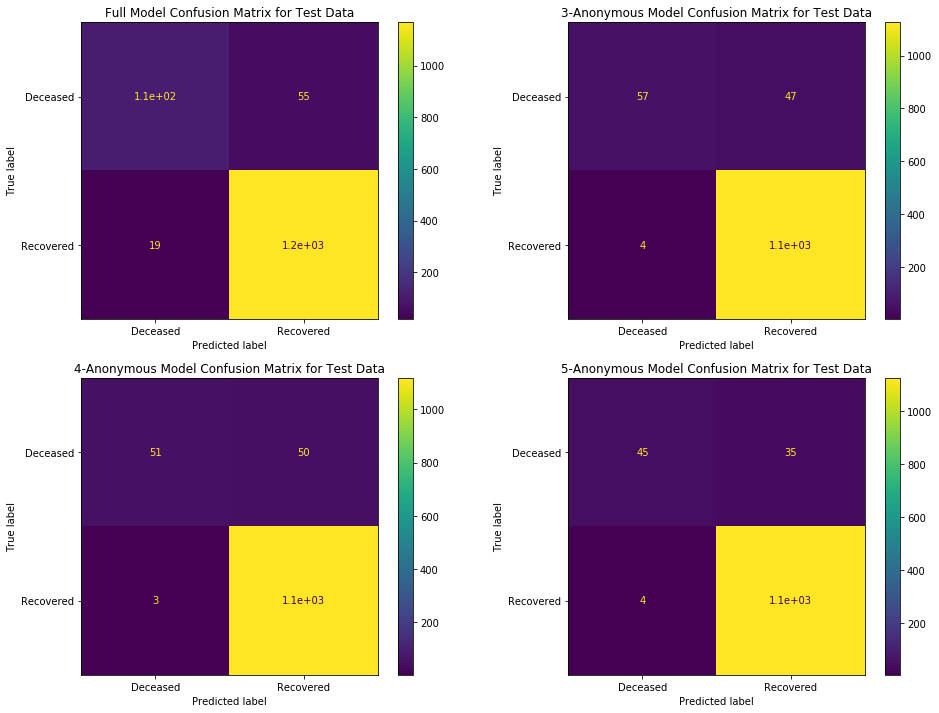

In [147]:
def testTrain(X, y):
    return train_test_split(X, y, test_size = 0.2, random_state = 42)

plt.figure(figsize = (16, 12))

# Loop over each dataset and build the model
counter = 0
for X, y, name in (X_full, y_full, 'Full'), (X_3, y_3, '3-Anonymous'), (X_4, y_4, '4-Anonymous'), (X_5, y_5, '5-Anonymous'):
    counter += 1
    
    X_train, X_test, y_train, y_test = testTrain(X, y)
    model = LogisticRegression(solver = 'lbfgs', max_iter = 1000).fit(X_train, y_train)
    trainScore = model.score(X_train, y_train)
    testScore = model.score(X_test, y_test)
    
    y_pred = model.predict(X_test)
    confMatrix = confusion_matrix(y_test, y_pred)
    
    print('Model:', name)
    
    # Get age's coefficient for the full model
    if name in ['Full', '3-Anonymous']:
        print('Age Bracket coef =', model.coef_[0, 0].round(3))
        
    print('Train accuracy:', trainScore.round(3))
    print('Test accuracy:', testScore.round(3))
    print(confMatrix)
    print()
    
    ax = plt.subplot(2, 2, counter)
    plot_confusion_matrix(model, X_test, y_test, display_labels = ['Deceased', 'Recovered'], cmap = None, ax = ax)
    plt.title(name + ' Model Confusion Matrix for Test Data')

Above, we can draw some interesting conclusions. First I wanted to see the coefficient on age in the two models that we included it in. The coefficient is negative, meaning that as age increases, the probability that an individual recovers decreases, which is what we would expect. I would have liked to look at the significance of the coefficients, but I was surprised to learn that sklearn does not support this. I tried to use statsmodels, but every time I tried I got an error that the X matrix was not singular. I suppose that there are two columns that are perfectly or almost perfectly correlated that I did not notice. I had the same error with sklearn but I increased the number of iterations and it seemed to work okay. I even tried simply predicting survival from only age, but I think statsmodels didn't like how little variance there was in the data.

Even on the test set, we see that our models all get upwards of 95% accuracy, which is impressive at first glance. If we only look at the accuracy of each model, we actually get the highest accuracy when using the 5-anonymous dataset. However, we see the full story when we look at the confusion matrices. First, we see that the data is extremely unbalanced, which is never a good thing. As I said earlier, if I was trying to get the most accurate model possible, I would have done some data balancing, but that was not the goal. We predict individuals that recovered with a very high accuracy. However, we predict deaths much less accurately. The best model for this is the full model, where we can predict a death with about 67% accuracy. However, in the other three models, our predictions are almost as good as just flipping a coin (in the 4-anonymous model we basically just flip a coin). The accuracy we have in the more anonymous models is 56% with the 5-anonymous model, and barely less at 54% with the 3-anonymous model, and only 50.5% in the 4-anonymous model.

## Conclusion

It is unfortunate that there is so much missing data in this dataset, as it really hinders our ability to analyze this data, create predictive models, or do anything really conclusive. We have almost 7000 data points, but of those, less than 500 even have the age of the individual, which is one of the most important attributes in predicting whether a person lives or dies that contracts this virus.

One rare place where missing data is helpful instead of harmful is with respect to privacy. If a value is missing, it is basically impossible to map this back to a specific individual, unless you have background knowledge of why the data is missing. In our analysis, we just treat the missing value as its own value and calculate the $k$-anonymity. The original data is 1-anonymous, which is not surprising. It would be really surprising to ever see a dataset that is more than 1-anonymous unless it had purposefully been made this way. However, because of the missing data, to achieve 3-, 4-, or even 5-anonymity, we only have to drop a few hundred rows.

Finally, we saw that as we make the dataset more anonymous, we do lose crucial information that helps us make predictions. We were able to accurately predict individuals that survived, but we made significantly more accurate predictions for deaths with the full dataset than with any of the anonymized datasets.

There is a lot of interesting future work that could still be done with this dataset. The first thing that could be done would be data balancing between the recoveries and deaths. Less than 10% of the original dataset is deaths, so it could be useful to upsample to make the amount of recoveries and deaths approximately equal. There are also lots of other models that could be applied to this problem that may be able to more accurately predict an individual surviving or dying. Finally, it also may be useful to simply wait for more data. The virus is still spreading and there are lots of people that are currently hospitalized, so there will only be more data in the future. There will likely be some very interesting analysis that people will be able to do a few years in the future after the virus has stopped spreading, which will hopefully be useful to prevent future outbreaks. This is the first large-scale outbreak that has happened in a long time, and now that we have fast computers that can do data analysis very quickly, we should be able to draw some interesting conclusions that should make it easier to prepare and prevent an outbreak like this from happening in the future